# Loading Pose detection output of Squat exercise

C:\Users\Asus\AppData\Local\Temp\ipykernel_17148\2388624981.py:9: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv("test_data.txt", index_col=False, names=df_header)


            TIME  NOSE_y  LEFT_EYE_y  RIGHT_EYE_y  LEFT_EAR_y  RIGHT_EAR_y  \
0  1619866801532   197.0       185.0        182.0       206.0        208.0   
1  1619866801679   200.0       188.0        188.0       208.0        210.0   
2  1619866802048   205.0       192.0        192.0       213.0        215.0   
3  1619866802161   204.0       190.0        190.0       212.0        212.0   
4  1619866802294   192.0       175.0        177.0       195.0        198.0   

   LEFT_SHOULDER_y  RIGHT_SHOULDER_y  LEFT_ELBOW_y  RIGHT_ELBOW_y  ...  \
0              NaN               NaN           NaN            NaN  ...   
1              NaN               NaN           NaN            NaN  ...   
2              NaN               NaN           NaN            NaN  ...   
3              NaN               NaN           NaN            NaN  ...   
4              NaN               NaN           NaN            NaN  ...   

   LEFT_ELBOW_x  RIGHT_ELBOW_x  LEFT_WRIST_x  RIGHT_WRIST_x  LEFT_HIP_x  \
0          

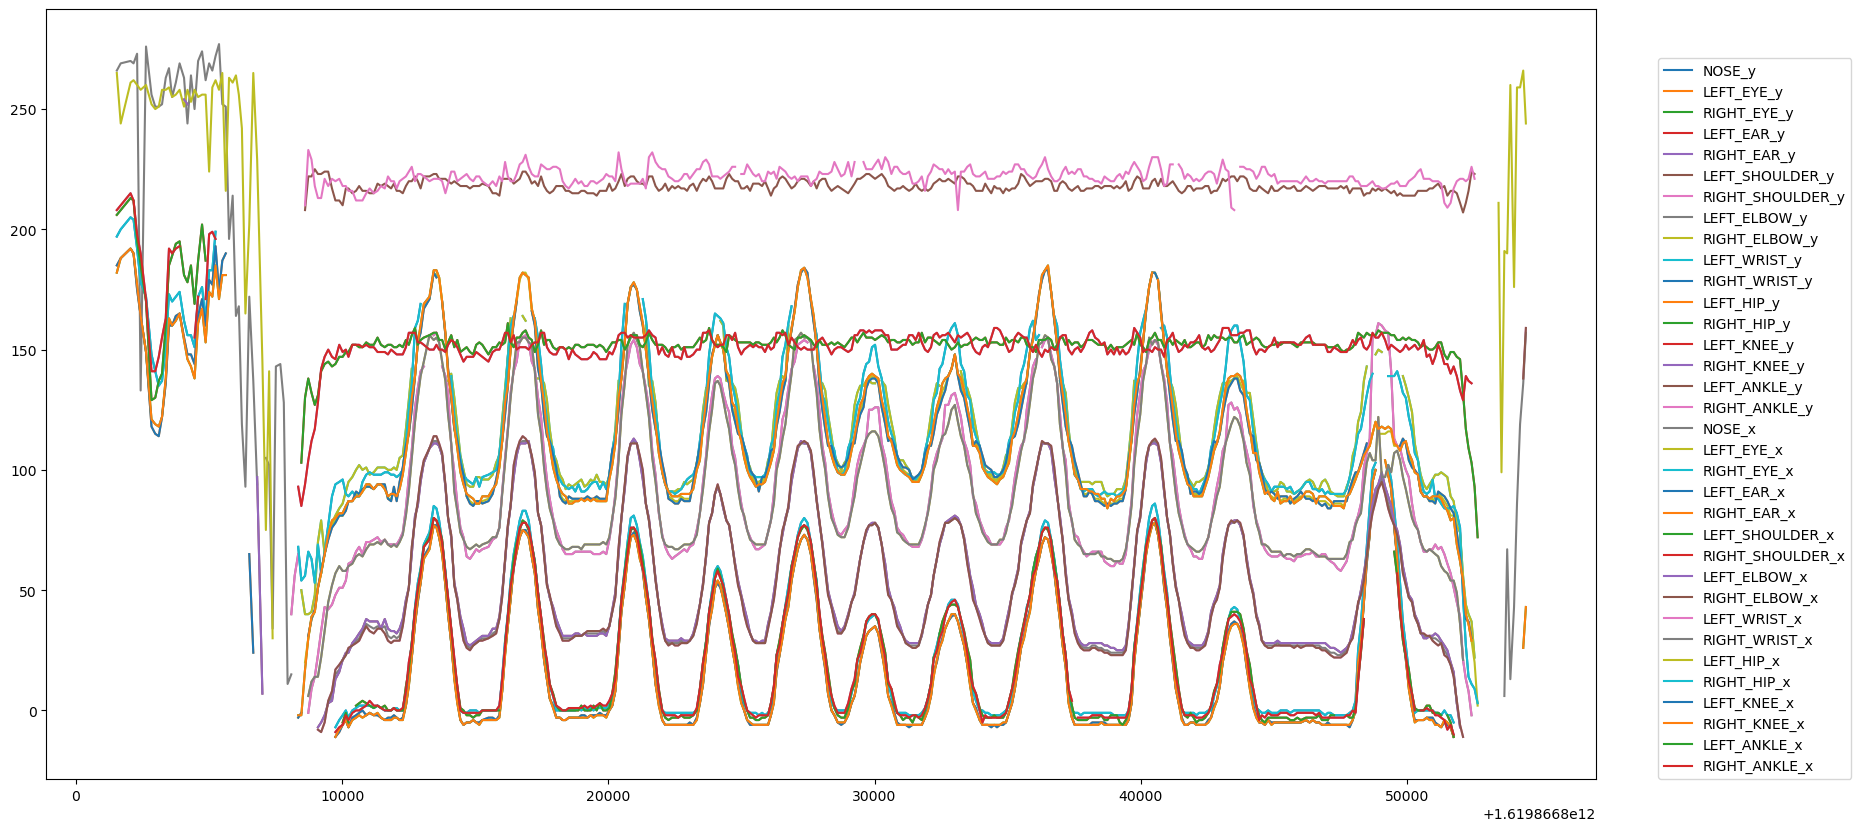

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
keypoints = ['NOSE','LEFT_EYE','RIGHT_EYE','LEFT_EAR','RIGHT_EAR','LEFT_SHOULDER','RIGHT_SHOULDER','LEFT_ELBOW','RIGHT_ELBOW','LEFT_WRIST','RIGHT_WRIST','LEFT_HIP','RIGHT_HIP','LEFT_KNEE','RIGHT_KNEE','LEFT_ANKLE','RIGHT_ANKLE']
keypoints_x, keypoints_y = [], []
for points in keypoints:
  keypoints_y.append(points + "_y")
  keypoints_x.append(points + "_x")
df_header = ['TIME'] + keypoints_y + keypoints_x
df = pd.read_csv("test_data.txt", index_col=False, names=df_header)
print(df.head())
def normalize(x):
  if (pd.isnull(x)):
    return x
  return int(int(x))

df["TIME"] = df["TIME"].apply(int)
for i in df.columns[1:]:
  df[i] = df[i].apply(normalize)

plt.figure(figsize=(20,10))
for i in df.columns[1:]:
  plt.plot(df["TIME"], df[i], label=str(i))
plt.legend(loc=(1.04,0))

original_df = df
import warnings
warnings.filterwarnings("ignore")

# Code to count squat reps and detect wrong reps in which the person did not go enough down (small peaks) while doing the exercise.

## Data Cleaning/Preprocessing.
Here we first replace negative entries with np.nan as -ve squats reps data is not making any sense.
Then we replace all np.nan entries with the entries generated by 'backfill' method.

            TIME  NOSE_y  LEFT_EYE_y  RIGHT_EYE_y  LEFT_EAR_y  RIGHT_EAR_y  \
0  1619866801532   197.0       185.0        182.0       206.0        208.0   
1  1619866801679   200.0       188.0        188.0       208.0        210.0   
2  1619866802048   205.0       192.0        192.0       213.0        215.0   
3  1619866802161   204.0       190.0        190.0       212.0        212.0   
4  1619866802294   192.0       175.0        177.0       195.0        198.0   

   LEFT_SHOULDER_y  RIGHT_SHOULDER_y  LEFT_ELBOW_y  RIGHT_ELBOW_y  ...  \
0            252.0               4.0          40.0            6.0  ...   
1            252.0               4.0          40.0            6.0  ...   
2            252.0               4.0          40.0            6.0  ...   
3            252.0               4.0          40.0            6.0  ...   
4            252.0               4.0          40.0            6.0  ...   

   LEFT_ELBOW_x  RIGHT_ELBOW_x  LEFT_WRIST_x  RIGHT_WRIST_x  LEFT_HIP_x  \
0         2

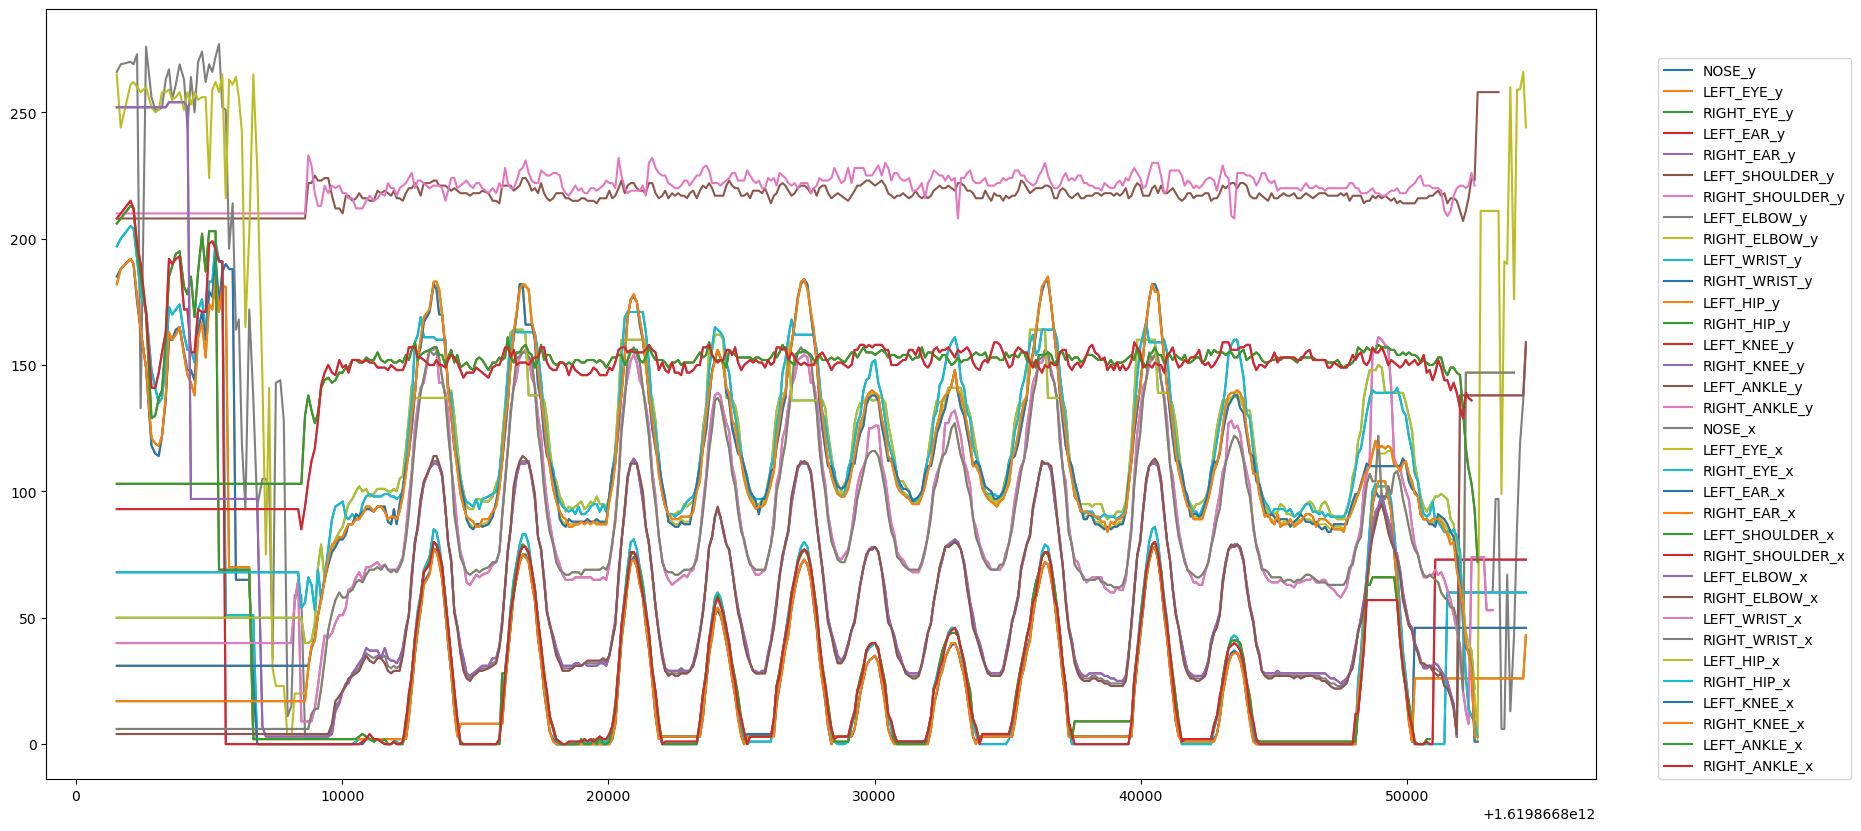

In [4]:
import numpy as np

df[df < 0] = np.nan

df = df.apply (pd.to_numeric, errors='coerce')

for i in df.columns[1:]:
  #df[i].fillna(value=df[i].mean(), inplace=True)
  df[i].fillna(value=None, method='backfill', axis=None, limit=None, downcast=None, inplace=True)

plt.figure(figsize=(20,10))
for i in df.columns[1:]:
  plt.plot(df["TIME"], df[i], label=str(i))
plt.legend(loc=(1.04,0))
print(df.head())
original_df = df

## Time-Series Analysis using certain algorithms.
Required featues for the data analysis of squat reps are as:  
'NOSE_y' , 'LEFT_EYE_y' , 'RIGHT_EYE_y' , 'LEFT_EAR_y' , 'RIGHT_EAR_y' , 'LEFT_SHOULDER_y' , 'RIGHT_SHOULDER_y' , 'LEFT_HIP_y' , 'RIGHT_HIP_y' , 'NOSE_x' , 'LEFT_EYE_x' ,  'RIGHT_EYE_x' , 'LEFT_EAR_x','RIGHT_EAR_x' , 'LEFT_SHOULDER_x' , 'RIGHT_SHOULDER_x' , 'LEFT_HIP_x' , 'RIGHT_HIP_x' , 'LEFT_KNEE_x' , 'RIGHT_KNEE_x'


In [6]:
from scipy.signal import find_peaks

def non_match(list_a, list_b):
    non_match = []
    for i in list_a:
        if i not in list_b:
            non_match.append(i)
    return non_match

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

t = 75
t1 = 410
labels = ['NOSE_y','LEFT_EYE_y','RIGHT_EYE_y','LEFT_EAR_y','RIGHT_EAR_y','LEFT_SHOULDER_y','RIGHT_SHOULDER_y','LEFT_HIP_y','RIGHT_HIP_y','NOSE_x','LEFT_EYE_x',
          'RIGHT_EYE_x','LEFT_EAR_x','RIGHT_EAR_x','LEFT_SHOULDER_x','RIGHT_SHOULDER_x','LEFT_HIP_x','RIGHT_HIP_x','LEFT_KNEE_x','RIGHT_KNEE_x']

thres = [80,73,73,67,61,100,100,157,157,100,157,80,73,73,67,59,151,163,157,157]
correct_squats = []

for i in range(len(labels)):
  x = df[labels[i]].to_numpy()

  peaks2, _ = find_peaks(x, prominence=25, distance=20)
  l3 = intersection(list(peaks2[peaks2>t]), list(peaks2[peaks2<t1]))
  q = x[np.asarray(np.unique(l3))]
  r = np.asarray(l3)
  total_reps = len(r)
  peaks2, _ = find_peaks(x, prominence=25, distance=20, height=thres[i])
  l3 = intersection(list(peaks2[peaks2>t]), list(peaks2[peaks2<t1]))
  w = x[np.asarray(np.unique(l3))]
  s = np.asarray(l3)
  correct_squats.append(len(l3))

correct_squats = np.array(correct_squats)
mean = correct_squats.mean()
print('Correct Squat Reps: {}'.format(int(mean)))
print('Wrong Squat Reps: {}'.format(len(non_match(q,w))))
print('Total Squat Reps: {}'.format(total_reps))


Correct Squat Reps: 6
Wrong Squat Reps: 5
Total Squat Reps: 11


## Visualization of Result Through Certain Plots.

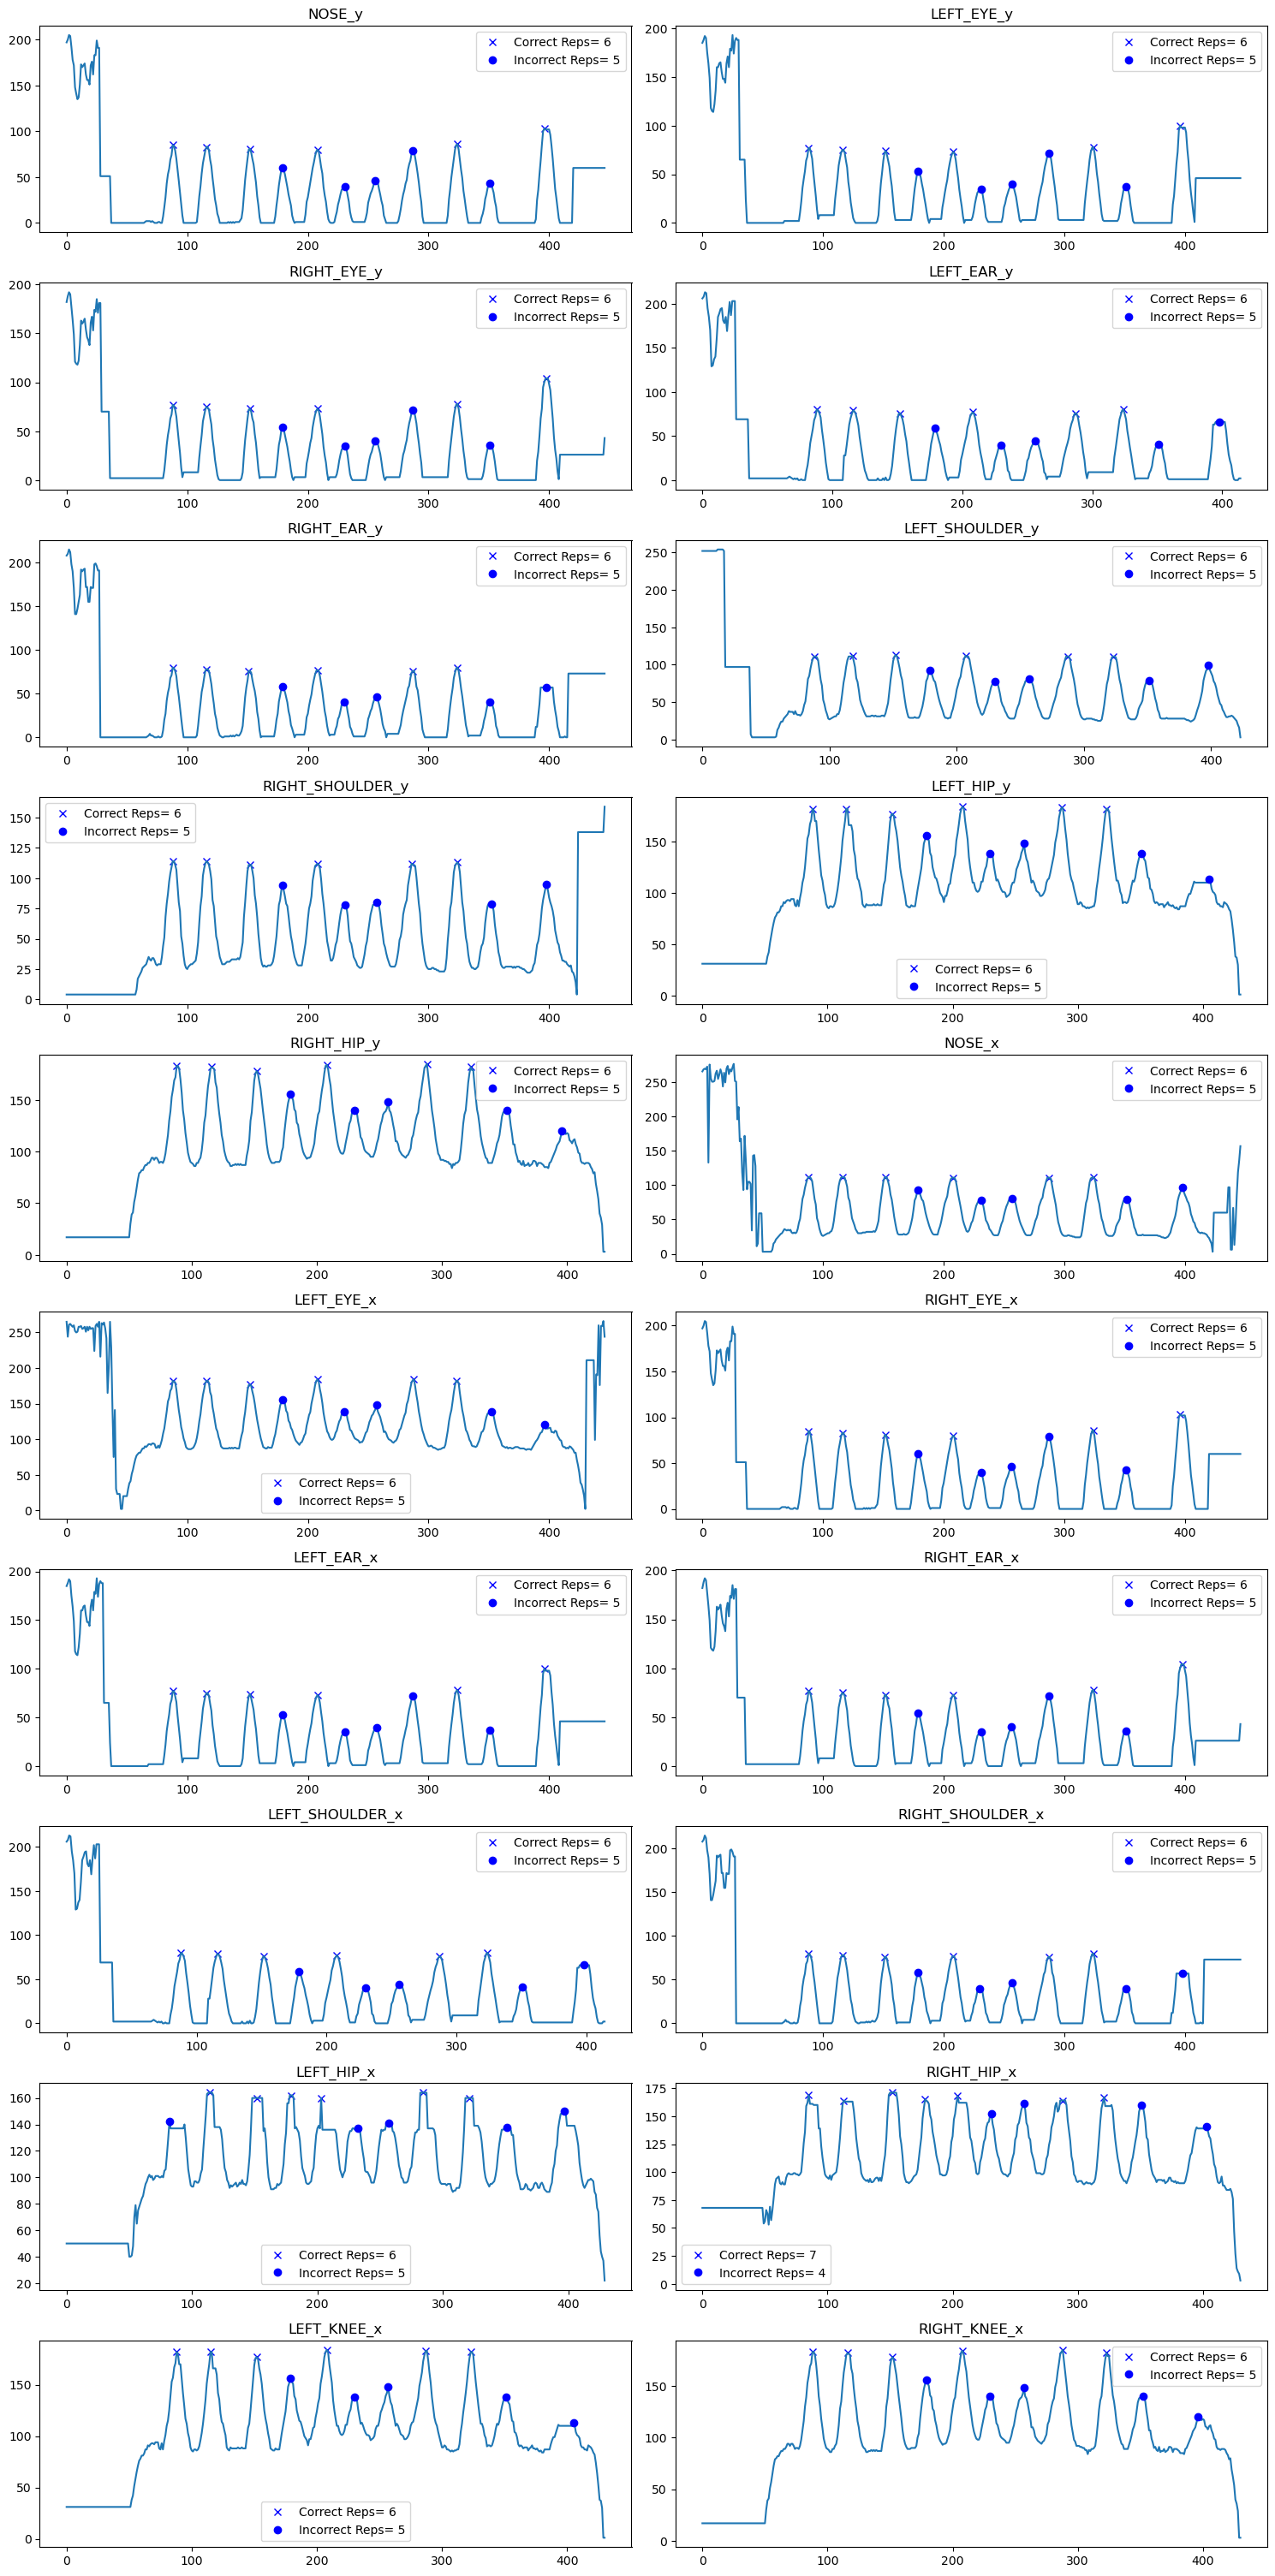

In [8]:
from scipy.signal import find_peaks

def non_match(list_a, list_b):
    non_match = []
    for i in list_a:
        if i not in list_b:
            non_match.append(i)
    return non_match

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

t = 75
t1 = 410
labels = ['NOSE_y','LEFT_EYE_y','RIGHT_EYE_y','LEFT_EAR_y','RIGHT_EAR_y','LEFT_SHOULDER_y','RIGHT_SHOULDER_y','LEFT_HIP_y','RIGHT_HIP_y','NOSE_x','LEFT_EYE_x',
          'RIGHT_EYE_x','LEFT_EAR_x','RIGHT_EAR_x','LEFT_SHOULDER_x','RIGHT_SHOULDER_x','LEFT_HIP_x','RIGHT_HIP_x','LEFT_KNEE_x','RIGHT_KNEE_x']

thres = [80,73,73,67,61,100,100,157,157,100,157,80,73,73,67,59,151,163,157,157]
plt.figure(figsize=(15,60))


for i in range(len(labels)):
  x = df[labels[i]].to_numpy()

  peaks2, _ = find_peaks(x, prominence=25, distance=20)
  l3 = intersection(list(peaks2[peaks2>t]), list(peaks2[peaks2<t1]))
  q = x[np.asarray(np.unique(l3))]
  r = np.asarray(l3)

  plt.subplot(20,2,i+1)
  peaks2, _ = find_peaks(x, prominence=25, distance=20, height=thres[i])
  l3 = intersection(list(peaks2[peaks2>t]), list(peaks2[peaks2<t1]))
  plt.plot(np.asarray(l3), x[np.asarray(np.unique(l3))], "xb", label='Correct Reps= {}'.format(len(l3))); plt.plot(x)#; plt.legend(['Correct Reps= {}'.format(len(l3))])
  w = x[np.asarray(np.unique(l3))]
  s = np.asarray(l3)
  plt.title(labels[i])


  plt.plot(np.asarray(non_match(r,s)) , np.asarray(non_match(q,w)) , 'ob', label='Incorrect Reps= {}'.format(len(non_match(q,w))))#; plt.legend(['Correct Reps= {}'.format(len(non_match(q,w)))])
  leg = plt.legend()


plt.tight_layout()
plt.show()